In [23]:
'''
!mkdir A2
%cd A2
!unzip ../A2.zip
%cd ..

!mkdir A_re2
%cd A_re2
!unzip ../A_re2.zip  
%cd ..


!mkdir A_re
%cd A_re
!unzip ../A_re.zip
%cd ..

!mkdir A
%cd A
!unzip ../A.zip
%cd ..

!mkdir B_re
%cd B_re
!unzip ../B_re.zip
%cd ..

!mkdir B
%cd B
!unzip ../B.zip
%cd ..

!mkdir E
%cd E
!unzip ../E.zip
%cd ..

!mkdir G
%cd G
!unzip ../G.zip
%cd ..

!mkdir H
%cd H
!unzip ../H.zip
%cd ..

'''

'\n!mkdir A2\n%cd A2\n!unzip ../A2.zip\n%cd ..\n\n!mkdir A_re2\n%cd A_re2\n!unzip ../A_re2.zip  \n%cd ..\n\n\n!mkdir A_re\n%cd A_re\n!unzip ../A_re.zip\n%cd ..\n\n!mkdir A\n%cd A\n!unzip ../A.zip\n%cd ..\n\n!mkdir B_re\n%cd B_re\n!unzip ../B_re.zip\n%cd ..\n\n!mkdir B\n%cd B\n!unzip ../B.zip\n%cd ..\n\n!mkdir E\n%cd E\n!unzip ../E.zip\n%cd ..\n\n!mkdir G\n%cd G\n!unzip ../G.zip\n%cd ..\n\n!mkdir H\n%cd H\n!unzip ../H.zip\n%cd ..\n\n'

In [24]:
import torch
import sys
import glob
sys.path.append('../DabbaMu-DEEP-TFM/aim2')
project_dir='/home/udith/udith_works/DabbaMu-DEEP-TFM/aim2'


In [25]:
#from adversarial_learning.swinIRwforward_support_files.models_define import swinIR_generative_decoder
#B_re
#exp_path= glob.glob('../exp_data_from_cluster/B_re/*/*/*/save_special')[0]
#other_opt_dir= 'adversarial_learning/swinIRwforward_support_files/opt.yaml' 

from adversarial_learning.swinIRwCustomUpwforward_support_files.models_define import swinIR_generative_decoder
#A_re2
exp_path= glob.glob('../exp_data_from_cluster/A_re2/*/*/*/save_special')[0]
other_opt_dir= 'adversarial_learning/swinIRwCustomUpwforward_support_files/opt.yaml'



In [26]:
device= 'cpu' #'cuda:0'

model_details = torch.load(f'{exp_path}/latest_model.pth', map_location= device)
cfg = model_details['cfg']
model_details.keys()

dict_keys(['cfg', 'epoch', 'm', 'decoder', 'losses_train', 'losses_val', 'metrics_train', 'metrics_val'])

In [27]:
from modules.models.forward_H import modelH_class
from modules.models.forward_model import modelA_class


from modules.models.preprocess_H_weights import * #ifft_2d_with_fftshift_real
from modules.custom_activations import sigmoid_custom
from modules.kernels import *
from modules.psfs import *


cfg.merge_from_list(['GENERAL.device', device])

T= cfg.MODEL.MODEL_H.T
img_size= cfg.DATASET.img_size
H_weight_preprocess= eval(cfg.MODEL.MODEL_H.H_weight_preprocess)
initialization_bias= cfg.MODEL.MODEL_H.initialization_bias
H_activation= eval(cfg.MODEL.MODEL_H.H_activation)
H_init = cfg.MODEL.MODEL_H.H_init
enable_train= False
lambda_scale_factor=cfg.MODEL.MODEL_A.lambda_scale_factor
sPSF= eval(cfg.MODEL.MODEL_A.sPSF)
exPSF= eval(cfg.MODEL.MODEL_A.exPSF)
noise=cfg.MODEL.MODEL_A.noise
rotation_lambda=cfg.MODEL.MODEL_A.rotation_lambda
shift_lambda_real=cfg.MODEL.MODEL_A.shift_lambda_real
readnoise_std=cfg.MODEL.MODEL_A.readnoise_std

modelH = modelH_class(T=T, img_size = img_size, preprocess_H_weights= H_weight_preprocess, 
                          device = device, 
                          initialization_bias=initialization_bias, 
                          activation = H_activation, init_method= H_init, 
                          enable_train=enable_train, lambda_scale_factor= lambda_scale_factor).to(device)

modelA= modelA_class(sPSF= sPSF.to(device), exPSF= exPSF.to(device), noise=noise, device = device, 
                        scale_factor=lambda_scale_factor, rotation_lambda=rotation_lambda, 
                        shift_lambda_real= shift_lambda_real,
                        readnoise_std= readnoise_std)

In [28]:
from modules.datasets import *
from modules.data_utils import return_dataloaders

total images found in: /home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/train -> 206976
total images found in: /home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/val -> 2112
total images found in: /home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/test -> 2112
dataset lenths : 3000 | 100 | 100


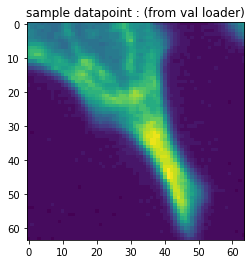

dataset value range :  0.003921568859368563 0.40784314274787903


In [29]:


get_dataset_func = bbbcHumanMCF7cellsW4cropped
delta= 0
num_samples_train= cfg.DATASET.num_samples_train
num_samples_valtest= cfg.DATASET.num_samples_valtest
batch_size_train= cfg.DATASET.batch_size_train
batch_size_valtest= cfg.DATASET.batch_size_valtest

drop_last_val_test= False

trainset, valset, testset = get_dataset_func(img_size= img_size, delta= delta, num_samples_train= num_samples_train, num_samples_valtest= num_samples_valtest)    
train_loader, val_loader, test_loader = return_dataloaders(trainset, valset, testset, batch_size_train= batch_size_train, drop_last_val_test= drop_last_val_test, batch_size_valtest= batch_size_valtest)


In [30]:
dec_state_dict= {}
for k, v in model_details['decoder'].items():
    if 'F_lossfn' in k:continue
    dec_state_dict[k]= v

In [31]:
decoder= swinIR_generative_decoder(f'{project_dir}/{other_opt_dir}', cfg, modelA, modelH)
decoder.load_state_dict(dec_state_dict)

../DabbaMu-DEEP-TFM/aim2/adversarial_learning/swinIRwCustomUpwforward_support_files/models_define.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  opt = yaml.load(file)


upsample net (custom_v2) is created succesfully inside SwinIR
Pass this initialization! Initialization was done during network defination!
Initialization method [orthogonal + uniform], gain is [0.20]
upsample net (custom_v2) is created succesfully inside SwinIR
Pass this initialization! Initialization was done during network defination!


<All keys matched successfully>

In [32]:
def get_preds_decoder(decoder, X):
    decoder.feed_data({'m':8, 'H':X})
    decoder.test()
    X_hat = decoder.E
    Ht= decoder.Ht
    yt_down= decoder.yt_down

    return X_hat, Ht, yt_down

In [33]:
import torchvision
transform = torchvision.transforms.Compose([
                                    torchvision.transforms.Grayscale(1),
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0,), (1,))])
            
def whole2patch(whole_img, H, W, img_size): #whole_img: (H, W), patch_imgs: (b, 1, img_size, img_size)
    patch_imgs = whole_img.reshape(H//img_size, img_size, W//img_size, img_size).permute(0, 2, 1, 3).flatten(start_dim=0, end_dim=1).unsqueeze(dim=1)
    return patch_imgs

def patch2whole(patch_imgs, H, W, img_size): # patch_imgs: (b, 1, img_size, img_size)
    out_recon= patch_imgs[:,0].reshape(H//img_size, W//img_size, img_size, img_size).permute(0, 2, 1, 3).flatten(start_dim=0, end_dim=1).flatten(start_dim=1, end_dim=2)
    return out_recon

In [34]:
import numpy as np

test_datasets= ['/home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/val']

In [35]:
'''

        plt.figure(figsize= (12,5))
        plt.subplot(1,2,1)
        plt.imshow(input_img, vmin=0,vmax=1)
        plt.subplot(1,2,2)
        plt.imshow(recon_img, vmin=0,vmax=1)
        plt.show()

        for _ in range(2):
            idx= np.random.randint(0, X.shape[0]-1)
            plt.figure(figsize= (6,6))
            plt.subplot(1,2,1)
            plt.imshow(X[idx, 0], vmin=0,vmax=1)
            plt.subplot(1,2,2)
            plt.imshow(X_hat[idx, 0], vmin=0,vmax=1)
            plt.show()
'''

'\n\n        plt.figure(figsize= (12,5))\n        plt.subplot(1,2,1)\n        plt.imshow(input_img, vmin=0,vmax=1)\n        plt.subplot(1,2,2)\n        plt.imshow(recon_img, vmin=0,vmax=1)\n        plt.show()\n\n        for _ in range(2):\n            idx= np.random.randint(0, X.shape[0]-1)\n            plt.figure(figsize= (6,6))\n            plt.subplot(1,2,1)\n            plt.imshow(X[idx, 0], vmin=0,vmax=1)\n            plt.subplot(1,2,2)\n            plt.imshow(X_hat[idx, 0], vmin=0,vmax=1)\n            plt.show()\n'

In [36]:
def pad_img(img, window_size, h_old, w_old): # input: img (A, B)
    h_pad = (h_old // window_size + 1) * window_size - h_old
    w_pad = (w_old // window_size + 1) * window_size - w_old
    img = torch.cat([img, torch.flip(img, [0])], 0)[:h_old + h_pad, :]
    img = torch.cat([img, torch.flip(img, [1])], 1)[:, :w_old + w_pad]

    return img

In [37]:
import torch
from torch.nn import functional as F
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from ignite.metrics import SSIM as SSIM_IGNITE
from ignite.metrics import PSNR

 
def ssim_ignite(X_hat, X, k= 11):
    metric = SSIM_IGNITE(data_range = 1.0, kernel_size= (k,k))
    metric.update((X_hat, X))
    return metric.compute().item()

def psnr_ignite(X_hat, X):
    metric = PSNR(data_range=1.0) #(data_range= 235- 16= 219) ->  https://scikit-image.org/docs/dev/api/skimage.color.html#rgb2ycbcr 
    metric.update((X_hat, X))
    return metric.compute().item()

In [38]:
import matplotlib.pyplot as plt
import glob

import torch
import cv2
import util
import numpy as np
from PIL import Image
from collections import OrderedDict

In [73]:


device= 'cuda:0'
window_size= 64
scale= 4


test_results = OrderedDict()
test_results['psnr'] = []
test_results['ssim'] = []
test_results['psnr_y'] = []
test_results['ssim_y'] = []
test_results['psnr_b'] = []


for border in [0, scale]:
    print('\n')
    for dataset_dir in test_datasets:

        i=0
        for img_dir in glob.glob(f'{dataset_dir}/*.png')[:100]:
            if i>4:break

            input_img = transform(Image.fromarray((255*plt.imread(img_dir)).astype('uint8')))[0]
            H, W = input_img.shape
            input_img_padded = pad_img(input_img, window_size, H, W)
            H_new, W_new = input_img_padded.shape

            X= whole2patch(input_img_padded, H_new, W_new, img_size)
            X_hat, Ht, yt_down = get_preds_decoder(decoder, X)
            X_hat, Ht, yt_down= X_hat.detach().cpu(), Ht.detach().cpu(), yt_down.detach().cpu()

            recon_img_padded = patch2whole(X_hat, H_new, W_new, img_size)
            recon_img= recon_img_padded[:H, :W]

            #### 
            output = (recon_img.unsqueeze(dim=2).cpu().detach().numpy() * 255.0).astype('uint8') #shape : HWC
            img_gt = (input_img.unsqueeze(dim=2).cpu().detach().numpy() * 255.0).astype('uint8') #shape : HWC
            
            psnr = util.calculate_psnr(output, img_gt, crop_border=border)
            ssim = util.calculate_ssim(output, img_gt, crop_border=border)

            test_results['psnr'].append(psnr)
            test_results['ssim'].append(ssim)
            if img_gt.ndim == 3:  # RGB image
                psnr_y = util.calculate_psnr(output, img_gt, crop_border=border, test_y_channel=True)
                ssim_y = util.calculate_ssim(output, img_gt, crop_border=border, test_y_channel=True)
                test_results['psnr_y'].append(psnr_y)
                test_results['ssim_y'].append(ssim_y)
                
        # summarize psnr/ssim
        if img_gt is not None:
            ave_psnr = sum(test_results['psnr']) / len(test_results['psnr'])
            ave_ssim = sum(test_results['ssim']) / len(test_results['ssim'])

            print(f'border = {border}  -->  Average PSNR/SSIM(RGB): {np.round(ave_psnr, 2)} dB; {np.round(ave_ssim, 4)}')
            #print('\n-- Average PSNR/SSIM(RGB): {:.2f} dB; {:.4f}'.format(ave_psnr, ave_ssim))



border = 0  -->  Average PSNR/SSIM(RGB): 43.2 dB; 0.9279


border = 4  -->  Average PSNR/SSIM(RGB): 43.21 dB; 0.9279


In [ ]:
import cv2
for idx, (x, y) in enumerate(val_loader):
    #print(x.shape, y)
    grid_img = torchvision.utils.make_grid(x, nrow=8)
    plt.figure(figsize= (10, 5))
    plt.imshow(cv2.cvtColor(grid_img.permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY))
    plt.show()

total images found in: /home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/train -> 206976
total images found in: /home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/val -> 2112
total images found in: /home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/test -> 2112
dataset lenths : 3000 | 100 | 100


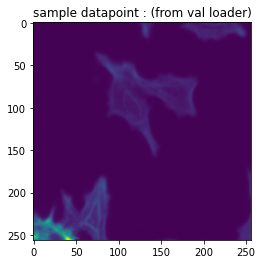

dataset value range :  0.007844130508601665 0.9450981616973877


In [34]:
sys.path.append('../DabbaMu-DEEP-TFM/aim2')

from modules.datasets import *
from modules.data_utils import return_dataloaders

get_dataset_func = bbbcHumanMCF7cellsW4

img_size, delta, num_samples_train= (256, 1e-06, 3000)
trainset, valset, testset = get_dataset_func(img_size= img_size, delta= delta, num_samples_train= num_samples_train, num_samples_valtest= 100)
train_loader, val_loader, test_loader = return_dataloaders(trainset, valset, testset, batch_size_train= 32, drop_last_val_test= True, batch_size_valtest= 1)

In [48]:
Xs, X_hats= [], []
window_size= 64
img_size= 64
for i, (x, y) in enumerate(val_loader):
    input_img = x[0,0]
    H, W = input_img.shape
    input_img_padded = pad_img(input_img, window_size, H, W)
    H_new, W_new = input_img_padded.shape

    X= whole2patch(input_img_padded, H_new, W_new, img_size)
    X_hat, Ht, yt_down = get_preds_decoder(decoder, X)
    X_hat, Ht, yt_down= X_hat.detach().cpu(), Ht.detach().cpu(), yt_down.detach().cpu()

    recon_img_padded = patch2whole(X_hat, H_new, W_new, img_size)
    recon_img= recon_img_padded[:H, :W]

    Xs.append(input_img.unsqueeze(dim=0).unsqueeze(dim=0).cpu().detach().numpy())
    X_hats.append(recon_img.unsqueeze(dim=0).unsqueeze(dim=0).cpu().detach().numpy())
gt = torch.from_numpy((255* np.array(Xs)).astype('uint8'))[:,0]
pred = torch.from_numpy((255* np.array(X_hats)).astype('uint8'))[:,0]


In [ ]:
import cv2
from modules.eval_metrics import ssim_ignite


plt.figure(figsize= (14, 10))
plt.subplot(2,1,1)
grid_img1 = torchvision.utils.make_grid(gt[3:6], nrow=3)
plt.imshow(cv2.cvtColor(grid_img1.permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY))
plt.title('gt')
plt.xticks([])
plt.yticks([])
plt.savefig('fig1_gt.png', dpi= 300)
plt.show()


plt.figure(figsize= (14, 10))
plt.subplot(2,1,2)
grid_img2 = torchvision.utils.make_grid(pred[3:6], nrow=3)
plt.imshow(cv2.cvtColor(grid_img2.permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY))
plt.title('pred')
plt.xticks([])
plt.yticks([])
plt.savefig('fig2_swinir.png', dpi= 300)
plt.show()

print('ssim : ', ssim_ignite(gt.float()/255.0, pred.float()/255.0))

In [39]:
window_size= 64
img_size= 64

i=1
img_dir= '/home/udith/udith_works/superres_eval/large_cell_imgs/bbbcHumanMCF7cells_sample_large_imgs/57.png' #94.png
input_img = transform(Image.fromarray((255*plt.imread(img_dir)).astype('uint8')))[0]
H, W = input_img.shape
input_img_padded = pad_img(input_img, window_size, H, W)
H_new, W_new = input_img_padded.shape

X= whole2patch(input_img_padded, H_new, W_new, img_size)
X_hat, Ht, yt_down = get_preds_decoder(decoder, X)
X_hat, Ht, yt_down= X_hat.detach().cpu(), Ht.detach().cpu(), yt_down.detach().cpu()

recon_img_padded = patch2whole(X_hat, H_new, W_new, img_size)
recon_img= recon_img_padded[:H, :W]

In [20]:
input_img.shape

torch.Size([1024, 1280])

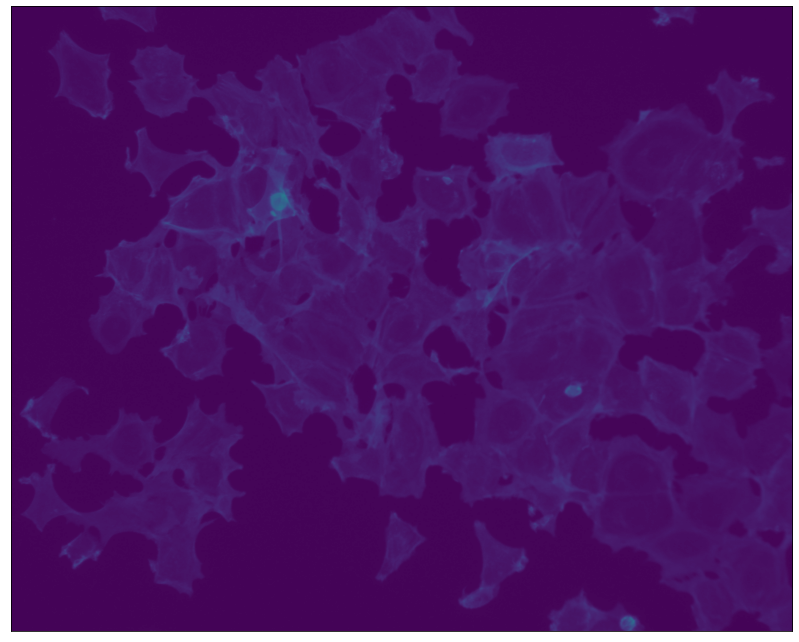

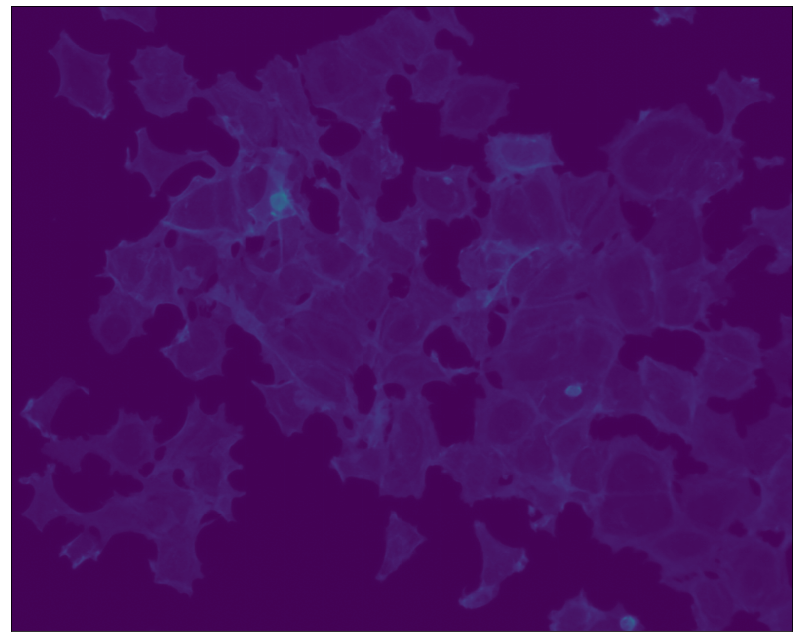

In [40]:

plt.figure(figsize= (14, 14))
plt.imshow(input_img, vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])
plt.savefig(f'./{i}_cellSR_gt.png', dpi= 300)
plt.show()

plt.figure(figsize= (14, 14))
plt.imshow(recon_img, vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])
plt.savefig(f'./{i}_cellSR_SwinrIR.png', dpi= 300)
plt.show()
